In [131]:
import numpy as np
import pandas as pd
import re
import nltk
import datetime
import seaborn as sns
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem.porter import *
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
path = '/Users/raisaurabh04/OneDrive/GreyAtom/Practice Dataset/sentiment_analysis.zip'

In [3]:
columns = ['target','ids','date','flag','user','text']

In [4]:
data = pd.read_csv(path, encoding='latin-1', header=None)

data.columns = columns

data.head()

data = data.sample(n=500000, random_state=22)

data.shape

data.head()

,target,ids,date,flag,user,text
1013875,4,1881370700,Fri May 22 04:27:56 PDT 2009,NO_QUERY,FreshPlastic,#followfriday @foyboy 1) She had Skips on her ...
1064419,4,1964672525,Fri May 29 14:36:52 PDT 2009,NO_QUERY,CarebearJK,@PaulaAbdul we are finally starting to see the...
290763,0,1995464536,Mon Jun 01 13:31:56 PDT 2009,NO_QUERY,jessicabalicki,w. all my old coworkers going to the wake RIP...
770144,0,2301890082,Tue Jun 23 16:03:01 PDT 2009,NO_QUERY,dlphntat,"yeah, Bravo TV. I so wanna learn more about th..."
1266526,4,1999668574,Mon Jun 01 20:36:58 PDT 2009,NO_QUERY,stevefroisland,"@JCTrick Thanks, J! I think I'm almost getting..."





<h3>Remove user handles and punctuations</h3>

In this task you will remove all user handles (if present) from every tweet with the help of regular expressions.

- Instructions

    - Declare a function remove_pattern which takes two arguments: input_txt (incoming tweet) and pattern (pattern to remove i.e. user handle)
    - This function first finds pattern within input_txt. You can achieve this by re.findall(pattern, input_txt). Save it as r which will be a list of matches
    - Now iterate over r and use re.sub(match, '', input_txt) to replace match with '' in input_txt
    - Finally return input_txt, which is the tweet free from the pattern (user handle)
    - Now use .apply(lambda row:remove_pattern(row, pattern)) method on data['text'] to create a new column 'clean_text' which is free from user handles. The pattern is "@[\w]*"
    - Print out the first five observations of data to check now where you have a new column 'clean_text' containing the tweets free from user handles

In [5]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for match in r:
        input_txt = re.sub(match, '', input_txt)
    return input_txt

pattern = '@[\w]*' #select the word thats starts with @ symbol

data['clean_text'] = data['text'].apply(lambda x : remove_pattern(x, pattern))


In [6]:
data.head()

,target,ids,date,flag,user,text,clean_text
1013875,4,1881370700,Fri May 22 04:27:56 PDT 2009,NO_QUERY,FreshPlastic,#followfriday @foyboy 1) She had Skips on her ...,#followfriday 1) She had Skips on her face ea...
1064419,4,1964672525,Fri May 29 14:36:52 PDT 2009,NO_QUERY,CarebearJK,@PaulaAbdul we are finally starting to see the...,we are finally starting to see the sun and wa...
290763,0,1995464536,Mon Jun 01 13:31:56 PDT 2009,NO_QUERY,jessicabalicki,w. all my old coworkers going to the wake RIP...,w. all my old coworkers going to the wake RIP...
770144,0,2301890082,Tue Jun 23 16:03:01 PDT 2009,NO_QUERY,dlphntat,"yeah, Bravo TV. I so wanna learn more about th...","yeah, Bravo TV. I so wanna learn more about th..."
1266526,4,1999668574,Mon Jun 01 20:36:58 PDT 2009,NO_QUERY,stevefroisland,"@JCTrick Thanks, J! I think I'm almost getting...","Thanks, J! I think I'm almost getting the han..."





<h3>Remove stopwords and perform stemming</h3>

In this task you will be tokenizing tweets, then remove stopwords and then tokenize every tweet and finally stem every word of the tweet.

- Instructions

    - We have already removed the stop words and store the result in stop_word

    - First tokenize data by applying .word_tokenize() method of nltk on every row of 'clean_text' column of data. Save this to a new column 'tokenized_text' on data

    - A variable stop_words has already been declared for you which stores the stop words and some common punctuation marks which can be removed. Make use of stop_words while removing stopwords.

    - Now remove stopwords from 'tokenized_text' column using .apply() method on every observation. Use a list comprehension like [word for word in row if word not in stop_words] to filter out stopwords. Save it to the same column 'tokenized_data'

    - Declare a Porter Stemmer object stemmer using PorterStemmer()

    - Use .apply() method on 'tokenized_text' column with lambda function lambda x: [stemmer.stem(i) for i in x] which converts every token into its respective root. Save it into the same column 'tokenized_data'

    - Finally join the words in every tweet (they are list elements) using .apply() method on every row with the lambda function lambda x: ' '.join(x)

    - Print out the first 5 observations

In [7]:
stop_words = list(set(stopwords.words('english')))+list(punctuation)+['``', "'s", "...", "n't"]

In [8]:
data['tokenized_text'] = data['clean_text'].apply(lambda x : nltk.word_tokenize(x))

data['tokenized_text'] = data['tokenized_text'].apply(lambda x : [word for word in x if word not in stop_words])

stemmer = PorterStemmer()

data['tokenized_text'] = data['tokenized_text'].apply(lambda x : [stemmer.stem(i) for i in x])

data['tokenized_text'] = data['tokenized_text'].apply(lambda x : ' '.join(x))

data.head()

data.shape

(500000, 8)




<h3>Which words occur most frequently?</h3>

With the help of wordcloud visualization you will observe which words occure frequently throughout the tweets.

- Instructions
    * First aggregate all the cleaned tweets (access by data['tokenized_text']) into a single list. Name this list all_words
    * Now generate a WordCloud object wordcloud using WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
    * Next step is to plot the above WordCloud. Use plt.imshow(wordcloud, interpolation='bilinear') and after that plt.axis('off') to have a look at the WordCloud object

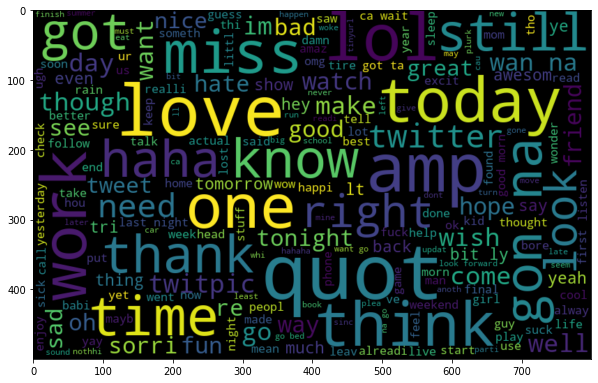

In [9]:
all_words = ' '.join([text for text in data['tokenized_text']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()



<h3>WordCloud visualization for negative tweets</h3>

In this task you will be doing a wordcloud visualization for words in negative tweets

- Instructions
    - Declare a list neg_words which stores entries for all the tweets (access by data['tokenized_text]data['target'] == 0). Then join every entry with a whitespace character using ' '.join([text for text in data['tokenized_text'][data['target'] == 0]])
    - Now generate a wordcloud object neg_wordcloud with arguments width=800, height=500, random_state=21, max_font_size=110 and use its method .generate(neg_words)
    - Then in a similar manner as the previous task plot the wordcloud visualization with .imshow() method of plt


(-0.5, 799.5, 499.5, -0.5)

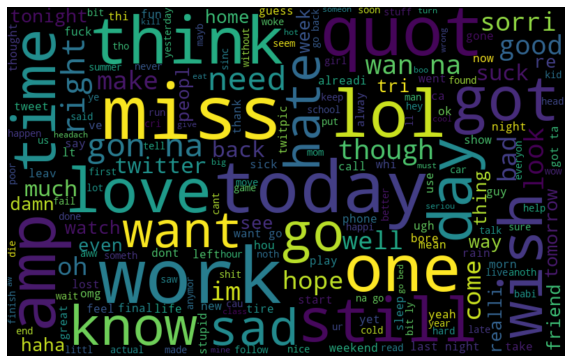

In [10]:
neg_words = ' '.join([text for text in data['tokenized_text'][data['target'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')3





<h3>Classify tweets as positive or negative</h3>

In this task you will be classifying tweets as either positive or negative by considering all neutral tweets as negative

Instructions
- Initialize a TF-IDF vectorizer tfidf_vectorizer with TfidfVectorizer() with arguments max_df=0.90 min_df=2, max_features=1000 and stop_words='english'
- Next fit and transform the tweets (data['tokenized_text]) using .fit_transform() method of tfidf_vectorizer. Save it to tweets
- In data['target'] series, convert all positive tweets with value 4 into value 1.
Now, split tweets into training and test sets. A number ratio has been declared for you. Split into X_train, X_test as tweets[:ratio,:] and tweets[ratio:,:] respectively. And split into y_train, y_test as data['target'].iloc[:ratio] and data['target'].iloc[ratio:]
- A logistic regression model logreg has already been defined for you. Fit logreg on training data i.e. X_train and y_train
- Make prediction using this fitted model on X_test using .predict_proba() method. It will give probabilities instead of classes. Save it as prediction
- Declare a variable prediction_int which stores the prediction probabilities for class 1. Do it using prediction[:,1] >= 0.3. And convert into np.int type .astype() method
- Calculate accuracy score by making use of the function accuracy_score(y_test, prediction_int). Save it as accuracy and print it out

In [11]:
ratio = int(len(data)*0.75)

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, max_features=1000, stop_words='english')

In [13]:
tweets = tfidf_vectorizer.fit_transform(data['tokenized_text'])

In [14]:
data['target'] = data['target'].map({4 : 1, 0 : 0})

In [15]:
X_train, X_test = tweets[:ratio,:], tweets[ratio:,:]

In [16]:
y_train, y_test = data['target'].iloc[:ratio], data['target'].iloc[ratio:]

In [17]:
logreg = LogisticRegression(random_state=2)

In [18]:
logreg.fit(X_train, y_train)

/Users/raisaurabh04/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=2, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
prediction = logreg.predict_proba(X_test)

In [20]:
prediction_int = (prediction[ : , 1] >= 0.3).astype(np.int)

In [21]:
accuracy = accuracy_score(y_test, prediction_int)





<h3>Use TextBlob to predict sentiments</h3>

Use TextBlob to predict polarity of sentiments (although they are known).

Instructions
- Declare an empty list tb_polarity which will store the polarities for every tweet coming from data['tokenized_text']
- Loop over data['tokenized_text'] using a for loop with an iterator sentence, then convert every sentence to a textBlob object using temp = TextBlob(sentence) and then append its polarity temp.sentiment[0] to tb_polarity
- After the for loop create a new column for data with the name 'tb_polarity' and assign it the value of the list tb_polarity

In [33]:
tb_polarity = []

for sentence in iter(data['tokenized_text']):
    temp = TextBlob(sentence)
    tb_polarity.append(temp.sentiment[0])

data['tb_polarity'] = tb_polarity

data.head()




<h3>Use VADER for analysing tweets</h3>

In this task you will be capturing the compound metric of VADER's output and use it as a sentiment polarity measure.

Instructions
- Initialize a sentiment analyser object analyser with SentimentIntensityAnalyzer()
- Declare an empty list vs_polarity where you will be storing the compound metric of every tweet
- Loop over data['tokenized_text'] with an iterator sentence and use .polarity_scores(sentence)['compound'] method of analyser. Add this to the list vs_polarity
- Make a new column 'vs_polarity' that stores the VADER compound polarity for every tweet by assigning its value equal to that of vs_polarity

In [39]:
analyser = SentimentIntensityAnalyzer()

vs_polarity = []

for sentence in iter(data['tokenized_text']):
    sentiment = analyser.polarity_scores(sentence)['compound']
    vs_polarity.append(sentiment)

data['vs_polarity'] = vs_polarity

# Assessment


<h3>Load data and convert timestamp</h3>
The first step - you know the drill by now - load the dataset and see how it looks like.

Instructions:
- Load dataset using pandas read_csv api in variable df,set parameter as sep ="\t" and give file path as path.
- Check the type of date.
- Convert the date attribute from string to datetime.date datatype
- Create a new column length and store the length of each of the verified_reviews in it.




In [78]:
path = '/Users/raisaurabh04/OneDrive/GreyAtom/Practice Dataset/sentiment_analysis_assessment_alexa_review.tsv'

In [80]:
df = pd.read_csv(path, sep='\t')

df['date'].dtypes

df['date'] = pd.to_datetime(df['date'])

df['length'] = df['verified_reviews'].apply(lambda x : len(x))



<h3>Rating vs feedback and Product rating vs feedback</h3>

As we are Amazon employee we need to focus on product ratings. So let's plot the the distribution of the rating so that we can focus on the negative ratings. Also, you need to plot the distribution of the product ratings so that we can focus on the negative ratings.

Instructions:
- plot the countplot for ratings where x = 'ratings', hue = feedback and data = df
- plot the barplot for ratings where x = 'ratings',y = "variation" hue = feedback and data = df

In [102]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,13
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,9
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,2018-07-31,Charcoal Fabric,Music,1,5


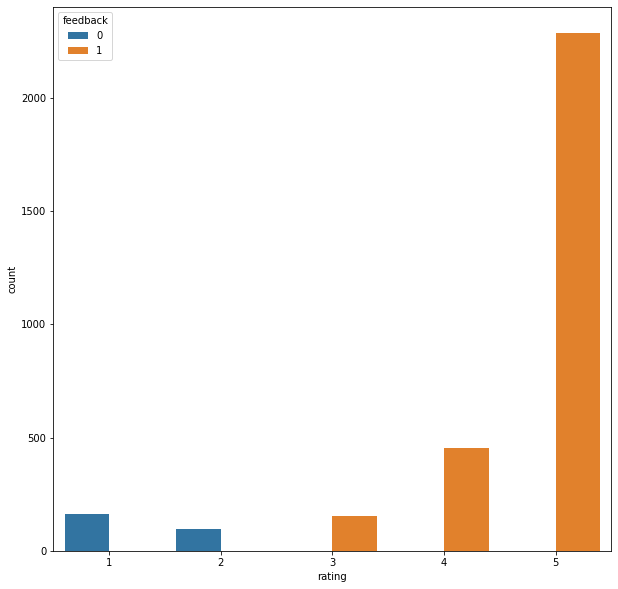

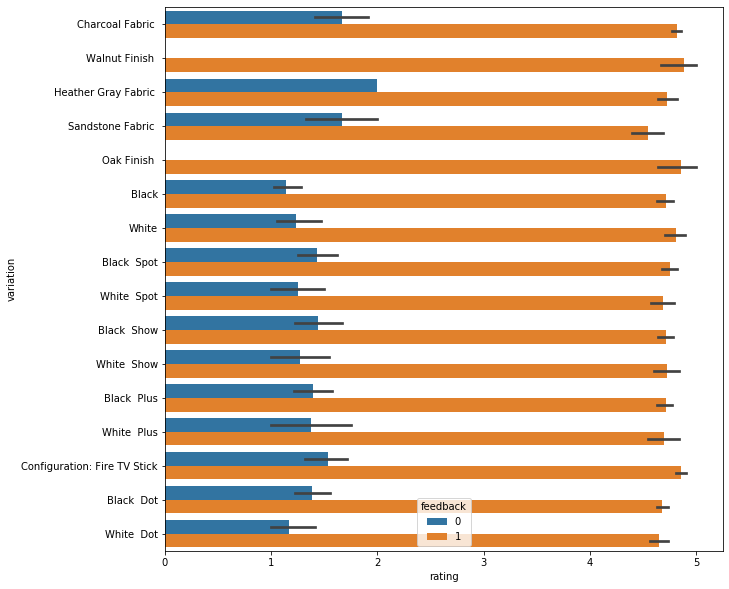

In [107]:
## Rating vs feedback

# set figure size
plt.figure(figsize=(10, 10))

# generate countplot
sns.countplot(x='rating', hue='feedback', data=df)

# display plot
plt.show()

## Product rating vs feedback

# set figure size
plt.figure(figsize=(10, 10))

# generate barplot
sns.barplot(x='rating', y='variation', hue='feedback', data=df)

# display plot
plt.show()






<h3>Data cleaning</h3>
As we know that we need to process on the review because some people wrote there feedback very inapropriate maner. so we need to clean the review. So let's work on cleaning the review

Instructions:
- Create a empty list corpus= []
- Apply the loop to iterate over every review where range is (0,3150).
- Convert the verified_reviews into replacement patterns and to the regular expression patterns and store it in variable review.
- Convert the reviews into lower order.
- Split the reviews
- Instantiate PorterStemmer() and store it in variable ps.
- Apply the PorterStemmer() and remove the stop words english
- Join the spaces in review' ' using ' '.join(review)
- Append the reviews in corpus

In [108]:
df.shape

(3150, 6)

In [110]:
df.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,2018-07-31,Charcoal Fabric,Love my Echo!,1,13
1,5,2018-07-31,Charcoal Fabric,Loved it!,1,9
2,4,2018-07-31,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,2018-07-31,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,2018-07-31,Charcoal Fabric,Music,1,5


In [109]:
corpus = []

In [117]:
stop_words = set(stopwords.words('english'))

In [118]:
for comment in df['verified_reviews']:
    review = re.sub('[^a-zA-Z]', ' ', comment)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(i) for i in review]
    review = [word for word in review if word not in stop_words]
    review = ' '.join(review)
    corpus.append(review)




<h3>Spliting the dataset</h3>

Now let's split the dataset into training and testing data.

Instructions:
- Instantiate CountVectorizer where max_features are 1500 and store it in variable cv.
- Fit and transform CountVectorizer on corpus,convert it to array and store it in variable X.
- store the dependent variable feedback on y.
- calculate the value count of feedback and store it in variable count
- Split the dataframe into X_train,X_test,y_train,y_test using train_test_split() function. Use test_size = 0.2 and random_state = 0

In [122]:
cv = CountVectorizer(max_features=1500)

In [125]:
X = cv.fit_transform(corpus).toarray()

In [126]:
y = df['feedback']

In [130]:
count = y.value_counts()

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)